In [25]:
import os
import pandas as pd

from utils.Logger import Logger
from utils.Experiments import Data, DataDomainwise, Settings, TrainOnce, PretrainingFinetuning, DomainAdversarialLearning
from utils.DataPreparation import prepare_data
from utils.Evaluation import evaluate

from Models.CDBLSTM import CDBLSTM
from Models.DACDBLSTM import DACDBLSTM

from sklearn.model_selection import train_test_split
import tensorflow as tf
tf.version.VERSION

'2.6.0'

## Read Data

In [27]:
hdf5_file = "../../1_Data/datasets.h5"
dataset_src = pd.read_hdf(hdf5_file, 'Simulated')
dataset_tar = pd.read_hdf(hdf5_file, 'Office_A')

In [28]:
dataset_src.head(2)

,Day,Time,CO2,Occupancy
0,2020-01-01,00:00:00,360.0,0.0
1,2020-01-01,00:01:00,360.0,0.0


In [29]:
dataset_tar.head(2)

,Day,Time,CO2,Temperature,Humidity,Occupancy
0,0,00:00:00,739.73,26.30,29.73,0
1,0,00:01:00,740.08,26.31,29.74,0


In [30]:
# apply early stopping
cb = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", 
                                        patience=5, min_delta=0.00001,
                                        verbose=0, restore_best_weights=True)]

## Target Only Training of CDBLSTM

In [31]:
training_days = 5
x_train, y_train, x_val, y_val, x_test, y_test = prepare_data(dataset_tar['CO2'].values, dataset_tar['Occupancy'].values, 
                                                              splitAt=[training_days*1440, training_days*2*1440], 
                                                              window_size=30)

train-validation-test split
split at [7200, 14400]
train: (7200, 30, 1) (7200, 1)
train: (7200, 30, 1) (7200, 1) test: (100771, 30, 1) (100771, 1)
train: (7200, 30, 1) (7200, 1) validate: (7200, 30, 1) (7200, 1) test: (100771, 30, 1) (100771, 1)
7200 training samples
data normalized to range [0, 1]
train: (7200, 30, 1) (7200, 1) validate: (7200, 30, 1) (7200, 1) test: (100768, 30, 1) (100768, 1)


Epoch 1/100
57/57 [==============================] - 15s 67ms/step - loss: 0.5947 - Accuracy: 0.6790 - val_loss: 0.6814 - val_Accuracy: 0.6006
Epoch 2/100
57/57 [==============================] - 1s 25ms/step - loss: 0.5471 - Accuracy: 0.6825 - val_loss: 0.6433 - val_Accuracy: 0.6111
Epoch 3/100
57/57 [==============================] - 1s 24ms/step - loss: 0.5372 - Accuracy: 0.6885 - val_loss: 0.6437 - val_Accuracy: 0.5800
Epoch 4/100
57/57 [==============================] - 1s 25ms/step - loss: 0.5285 - Accuracy: 0.7057 - val_loss: 0.6139 - val_Accuracy: 0.6107
Epoch 5/100
57/57 [==============================] - 1s 26ms/step - loss: 0.5232 - Accuracy: 0.7129 - val_loss: 0.7004 - val_Accuracy: 0.5906
Epoch 6/100
57/57 [==============================] - 1s 26ms/step - loss: 0.5280 - Accuracy: 0.7114 - val_loss: 0.6075 - val_Accuracy: 0.6343
Epoch 7/100
57/57 [==============================] - 1s 25ms/step - loss: 0.5251 - Accuracy: 0.7163 - val_loss: 0.6520 - val_Accuracy: 0.5843
Epoch

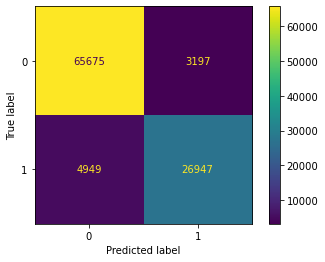

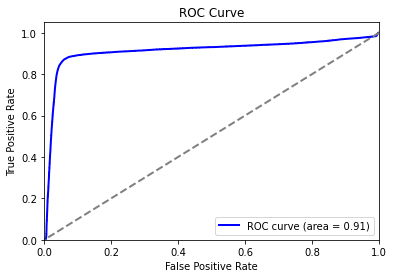

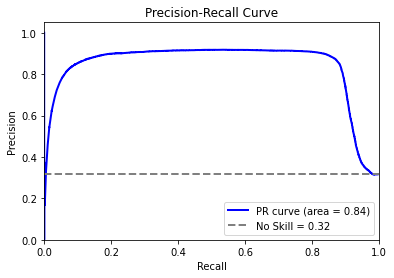

{'Accuracy': 0.9191608447126072,
 'Balanced Accuracy': 0.8992100167686927,
 'F1-Score': 0.8686976144422953,
 'Precision': 0.8939424097664543,
 'Recall': 0.8448394783044896,
 'Matthews Correlation Coefficient': 0.8110437612453039,
 'Cohens Kappa': 0.8103689328047861,
 'ROC-AUC': 0.911658389661131,
 'PR-AUC': 0.8361651632751375,
 'Loss': 0.31309712}

In [32]:
from Models.CDBLSTM import CDBLSTM 
# alternatively import DACDBLSTM from Models.DACDBLSTM and train DACDBLSTM.task_classifier

model = CDBLSTM(classes=2, features=1, window_size=30, batch_size=128)
model.fit(x_train, y_train, epochs=100, batch_size=128,
            validation_data=(x_val, y_val), callbacks=cb)
evaluate(model, x_test, y_test, verbose=1)

## Domain-Adversarial Learning

In [33]:
training_days=5
x_train, y_train, x_val, y_val, x_test, y_test = prepare_data(dataset_tar['CO2'].values, dataset_tar['Occupancy'].values,
                                                                              [dataset_src['CO2'].values], [dataset_src['Occupancy'].values],
                                                                              splitAt=[training_days*1440, training_days*2*1440], window_size=30)

train-validation-test split
split at [7200, 14400]
train: (7200, 30, 1) (7200, 1)
train: (7200, 30, 1) (7200, 1) test: (100771, 30, 1) (100771, 1)
train: (7200, 30, 1) (7200, 1) validate: (7200, 30, 1) (7200, 1) test: (100771, 30, 1) (100771, 1)
7200 training samples from target domain
143971 training samples from source domain 1
data normalized to range [0, 1]
train: (151168, 30, 1) (2, 151168, 1) validate: (7200, 30, 1) (2, 7200, 1) test: (100768, 30, 1) (2, 100768, 1)


['window_size=30']
Epoch 1/100
1181/1181 [==============================] - 48s 29ms/step - loss: 0.6812 - task_output_loss: 0.4044 - domain_output_loss: 0.2768 - task_output_accuracy: 0.8139 - domain_output_accuracy: 0.9226 - val_loss: 3.4426 - val_task_output_loss: 0.5542 - val_domain_output_loss: 2.8885 - val_task_output_accuracy: 0.7296 - val_domain_output_accuracy: 0.0000e+00
Epoch 2/100
1181/1181 [==============================] - 30s 26ms/step - loss: 0.4118 - task_output_loss: 0.2236 - domain_output_loss: 0.1883 - task_output_accuracy: 0.9262 - domain_output_accuracy: 0.9524 - val_loss: 3.5323 - val_task_output_loss: 0.7002 - val_domain_output_loss: 2.8321 - val_task_output_accuracy: 0.6825 - val_domain_output_accuracy: 0.0000e+00
Epoch 3/100
1181/1181 [==============================] - 29s 25ms/step - loss: 0.3953 - task_output_loss: 0.2073 - domain_output_loss: 0.1880 - task_output_accuracy: 0.9365 - domain_output_accuracy: 0.9524 - val_loss: 3.2129 - val_task_output_loss: 0.

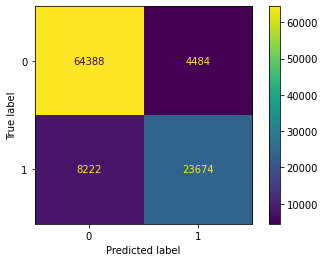

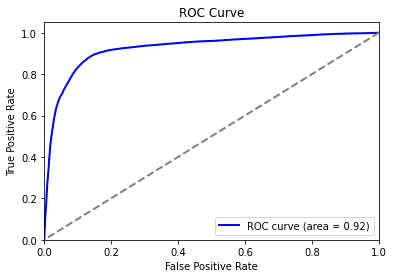

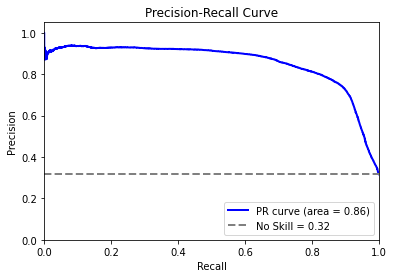

{'Accuracy': 0.8739083836138457,
 'Balanced Accuracy': 0.8385592231262231,
 'F1-Score': 0.7884237519565725,
 'Precision': 0.8407557354925776,
 'Recall': 0.7422247303737146,
 'Matthews Correlation Coefficient': 0.7018672581187667,
 'Cohens Kappa': 0.6991120867880736,
 'ROC-AUC': 0.9248579386210405,
 'PR-AUC': 0.855371798125957,
 'Loss': 0.34111744}

In [9]:
from Models.DACDBLSTM import DACDBLSTM

model = DACDBLSTM(classes=2, features=1, domains=2, window_size=30)

model.fit(x_train, {"task_output": y_train[0], 
                    "domain_output": y_train[1]}, 
                    epochs=100, batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=cb)

evaluate(model, x_test, y_test[0], verbose=1)

## Pretraining & Fine-Tuning

In [10]:
training_days = 5
x_train_tar, y_train_tar, x_val_tar, y_val_tar, x_test, y_test = \
                            prepare_data(dataset_tar['CO2'].values, dataset_tar['Occupancy'].values, 
                                            splitAt=[training_days*1440, training_days*2*1440], 
                                            window_size=30)

x_train_src, y_train_src, x_val_src, y_val_src = \
                            prepare_data(dataset_src['CO2'].values, dataset_src['Occupancy'].values, 
                                            splitAt=0.8, window_size=30)

train-validation-test split
split at [7200, 14400]
train: (7200, 30, 1) (7200, 1)
train: (7200, 30, 1) (7200, 1) test: (100771, 30, 1) (100771, 1)
train: (7200, 30, 1) (7200, 1) validate: (7200, 30, 1) (7200, 1) test: (100771, 30, 1) (100771, 1)
7200 training samples
data normalized to range [0, 1]
train: (7200, 30, 1) (7200, 1) validate: (7200, 30, 1) (7200, 1) test: (100768, 30, 1) (100768, 1)
train-test split
split at index 115177
train: (115177, 30, 1) (115177, 1)
train: (115177, 30, 1) (115177, 1) test: (28794, 30, 1) (28794, 1)
115177 training samples
data normalized to range [0, 1]
train: (115168, 30, 1) (115168, 1) test: (28768, 30, 1) (28768, 1)


Epoch 1/100
900/900 [==============================] - 31s 19ms/step - loss: 0.3634 - Accuracy: 0.8479 - val_loss: 0.1959 - val_Accuracy: 0.9375
Epoch 2/100
900/900 [==============================] - 15s 16ms/step - loss: 0.2318 - Accuracy: 0.9247 - val_loss: 0.1916 - val_Accuracy: 0.9421
Epoch 3/100
900/900 [==============================] - 15s 16ms/step - loss: 0.1996 - Accuracy: 0.9394 - val_loss: 0.1752 - val_Accuracy: 0.9479
Epoch 4/100
900/900 [==============================] - 15s 17ms/step - loss: 0.1901 - Accuracy: 0.9425 - val_loss: 0.1953 - val_Accuracy: 0.9410
Epoch 5/100
900/900 [==============================] - 15s 17ms/step - loss: 0.1915 - Accuracy: 0.9427 - val_loss: 0.1639 - val_Accuracy: 0.9525
Epoch 6/100
900/900 [==============================] - 15s 17ms/step - loss: 0.1750 - Accuracy: 0.9491 - val_loss: 0.1498 - val_Accuracy: 0.9536
Epoch 7/100
900/900 [==============================] - 15s 17ms/step - loss: 0.1630 - Accuracy: 0.9519 - val_loss: 0.1396 - val_Ac

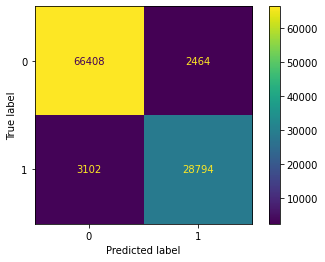

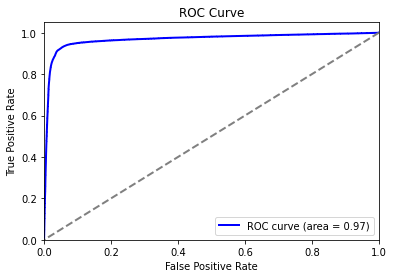

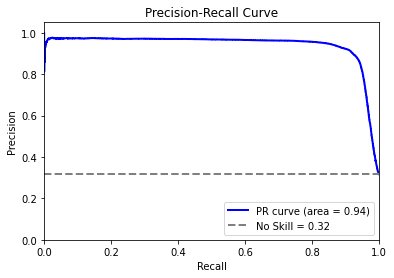

{'Accuracy': 0.9447642108605907,
 'Balanced Accuracy': 0.9334849564662805,
 'F1-Score': 0.9118662317509579,
 'Precision': 0.92117217992194,
 'Recall': 0.9027464258841233,
 'Matthews Correlation Coefficient': 0.8717445625407217,
 'Cohens Kappa': 0.8716502155626761,
 'ROC-AUC': 0.9674710606070671,
 'PR-AUC': 0.9406429474272944,
 'Loss': 0.1838109}

In [11]:
model = CDBLSTM(classes=2, features=1, window_size=30, batch_size=128)

# pretrain
model.fit(x_train_src, y_train_src, epochs=100, batch_size=128,
            validation_data=(x_val_src, y_val_src), callbacks=cb)
# fine-tune
model.fit(x_train_tar, y_train_tar, epochs=100, batch_size=128,
            validation_data=(x_val_tar, y_val_tar), callbacks=cb)
           
evaluate(model, x_test, y_test, verbose=1)

## Layer Freezing

Epoch 1/100
900/900 [==============================] - 28s 19ms/step - loss: 0.3566 - Accuracy: 0.8534 - val_loss: 0.2067 - val_Accuracy: 0.9337
Epoch 2/100
900/900 [==============================] - 15s 16ms/step - loss: 0.2232 - Accuracy: 0.9296 - val_loss: 0.1962 - val_Accuracy: 0.9397
Epoch 3/100
900/900 [==============================] - 15s 16ms/step - loss: 0.2031 - Accuracy: 0.9368 - val_loss: 0.1774 - val_Accuracy: 0.9444
Epoch 4/100
900/900 [==============================] - 14s 16ms/step - loss: 0.1937 - Accuracy: 0.9403 - val_loss: 0.1725 - val_Accuracy: 0.9494
Epoch 5/100
900/900 [==============================] - 14s 16ms/step - loss: 0.1927 - Accuracy: 0.9408 - val_loss: 0.1605 - val_Accuracy: 0.9511
Epoch 6/100
900/900 [==============================] - 14s 16ms/step - loss: 0.2077 - Accuracy: 0.9327 - val_loss: 0.1594 - val_Accuracy: 0.9526
Epoch 7/100
900/900 [==============================] - 14s 16ms/step - loss: 0.1742 - Accuracy: 0.9471 - val_loss: 0.1853 - val_Ac

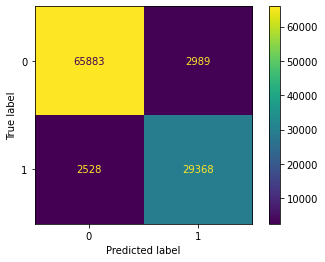

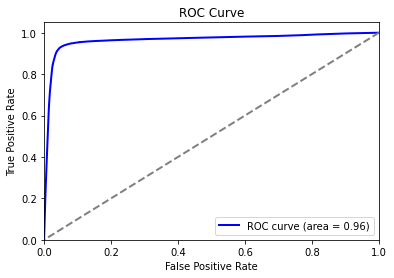

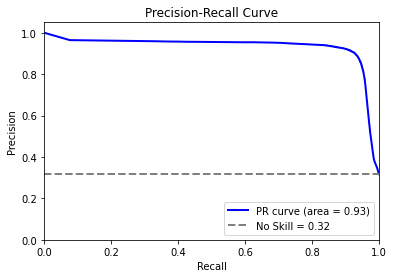

{'Accuracy': 0.9452504763416958,
 'Balanced Accuracy': 0.9386715316618947,
 'F1-Score': 0.9141363049196146,
 'Precision': 0.9076243162221467,
 'Recall': 0.9207424128417356,
 'Matthews Correlation Coefficient': 0.8740007626200187,
 'Cohens Kappa': 0.8739522829436116,
 'ROC-AUC': 0.9639213977690242,
 'PR-AUC': 0.932466099265379,
 'Loss': 0.20629688}

In [12]:
model = CDBLSTM(classes=2, features=1, window_size=30, batch_size=128)

# pretrain
model.fit(x_train_src, y_train_src, epochs=100, batch_size=128,
            validation_data=(x_val_src, y_val_src), callbacks=cb)

# freeze layers of CNN
for layer in model.layers[0:4]:
    layer.trainable = False
print("trainable layers:")
print([(l.name, l.trainable) for l in model.layers])
model.recompile() # recompile the model after freezing layers!

# fine-tune
model.fit(x_train_tar, y_train_tar, epochs=100, batch_size=128,
            validation_data=(x_val_tar, y_val_tar), callbacks=cb)
           
evaluate(model, x_test, y_test, verbose=1)